In [29]:
#Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [30]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(10,4)}
        )

In [19]:
#Загружаем данные
df = pd.read_csv('hw_aa.csv', sep=';', index_col='Unnamed: 0')

Прежде чем приступать к заданию изучим наши данные

In [9]:
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [16]:
df.shape

(127018, 4)

In [17]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [18]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [20]:
df.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

Разделим данные на 2 датафрейма

In [24]:
df_0 = df.query('experimentVariant == 0')

In [25]:
df_1 = df.query('experimentVariant == 1')

## Задача
- Запустите A/A-тест
- Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
- Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
- Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [32]:
simulations = 1000
n_s = 1000
res = []

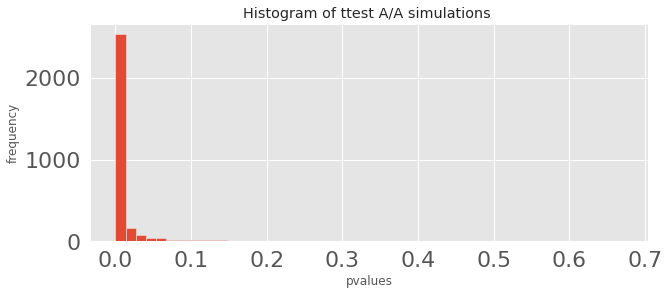

In [69]:
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_0['purchase'].sample(n_s, replace = False).values
    s2 = df_1['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [70]:
# Проверяем, что количество ложноположительных случаев не превышает альфа = 0.05
sum(np.array(res) < 0.05) / simulations

2.802

**FPR > альфа! Сплит-система сломана**

Найдем причину поломки!

In [75]:
#Cчитаем конверсию, группируя по варианту и версии МП.
df.groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'purchase':'mean'}).rename(columns={"purchase": "CTR"})

,experimentVariant,version,CTR
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Видим сильные отличия в конверсии для версии МП v2.8.0. Проведем для нее отдельный А/А тест

In [117]:
df_0_v28 = df.query('experimentVariant == 0 & version == "v2.8.0"')

In [118]:
df_1_v28 = df.query('experimentVariant == 1 & version == "v2.8.0"')

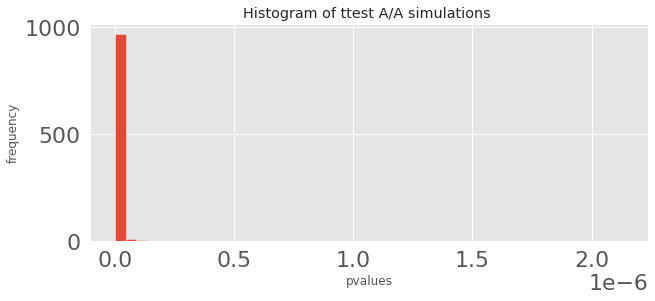

In [119]:
# Запуск симуляций A/A теста
res = []
for i in tqdm(range(simulations)):
    s1 = df_0_v28['purchase'].sample(n_s, replace = False).values
    s2 = df_1_v28['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [113]:
# Проверяем, что количество ложноположительных случаев не превышает альфа = 0.05
sum(np.array(res) < 0.05) / simulations

1.0

**FPR > альфа!**

In [127]:
df_0_new = df.query('experimentVariant == 0 & version != "v2.8.0"')

In [128]:
df_1_new = df.query('experimentVariant == 1 & version != "v2.8.0"')

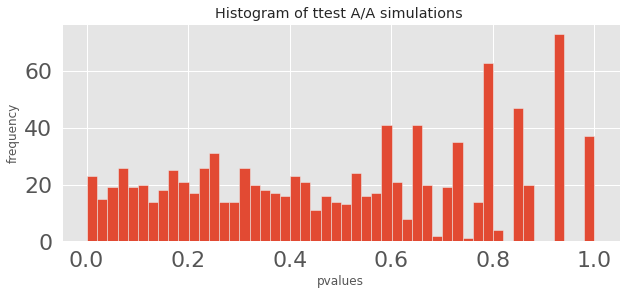

In [129]:
# Запуск симуляций A/A теста
res = []
for i in tqdm(range(simulations)):
    s1 = df_0_new['purchase'].sample(n_s, replace = False).values
    s2 = df_1_new['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [130]:
# Проверяем, что количество ложноположительных случаев не превышает альфа = 0.05
sum(np.array(res) < 0.05) / simulations

0.046

**FPR < альфа!**

In [131]:
#Посмотрим в разбивке на количество пользователей 
df.groupby(['experimentVariant', 'version']).agg({'version':'count'})

version
experimentVariant version          
0                 v2.8.0      41283
                  v2.9.0      11921
                  v3.7.4.0     4204
                  v3.8.0.0     5694
1                 v2.8.0      41552
                  v2.9.0      12033
                  v3.7.4.0     4221
                  v3.8.0.0     6110

## Выводы

**Сплит-система сломана для версии МП 2.8.0.** 

В этой версии криво реализован сплит-алгоритм, так как конверсия в этой версии сильно отличается, в отличии от других версий, а количество пользователей в группах примерно равно.
